In [1]:
if 0: # set to 1 to install MIDI library mido:
    !pip3 install mido

In [2]:
if 0: # set to 1 tom install librosa (for converting midi notes to freq/symbol)
    !pip3 install librosa

(Note: if using datahub, just installing mido didn't seem to let ```import mido``` work on the same session...might need to log out and log back in to restart the Jupyter sever)

In [3]:
import mido
print('Importing mido from path:', mido.__file__)

Importing mido from path: /home/auppal/.local/lib/python3.9/site-packages/mido/__init__.py


List all MIDI files in the imagery dataset:

In [4]:
from glob import glob
mid_files = glob('data/musicImagery/stimuli/midi/**.mid')

for mid_path in mid_files:
    print(mid_path)


data/musicImagery/stimuli/midi/chor-019.mid
data/musicImagery/stimuli/midi/chor-101.mid
data/musicImagery/stimuli/midi/chor-096.mid
data/musicImagery/stimuli/midi/chor-038.mid


In [5]:
def get_midi_events(mid_path, TICKS_PER_BEAT = 480, print_out = False):
    
    """
    This function generates `mid_events`: a dict of tracks in the MIDI file.
    Each track gets a list of `track_events`.
    Each event in `track_events` is formatted as:
        [MIDI note, start time (ms), stop time (ms)]
        
    This has only been tested on MIDI files where only one note is played at one time (no overlapping notes)
    """
    
    # this will become a dict of tracks (with events) in the MIDI file
    mid_events = {}
    
    # Code here is motivated from examples in mido's documentation:
    # (from https://mido.readthedocs.io/en/latest/midi_files.html)
    
    # Open the MIDI file
    mid = mido.MidiFile(mid_path, ticks_per_beat=TICKS_PER_BEAT)
    
    # Iterate through all tracks and collect 
    # - tempo info
    # - note on/off events
    
    for track_idx, track in enumerate(mid.tracks):
        
        if print_out:
            print('Track {}: {}'.format(track_idx, track.name))
            print('-'*50)
        
        # Timekeeper for the MIDI file
        global_ticks = 0
        
        # Container for collecting all note events
        track_events = []
        
        # Read all the messages for the given track
        for msg in track:
            
            if print_out:
                print(msg)
                    
            # Collect time information for this event
            delta_ticks = msg.time
            global_ticks += delta_ticks
            
            # Check if we have tempo information in this message
            if msg.is_meta and msg.type=='set_tempo':
                    
                # https://mido.readthedocs.io/en/latest/midi_files.html#about-the-time-attribute
                MICROS_PER_BEAT = msg.tempo
                
                if print_out:
                    print(f'>> Tempo (µs/beat): {MICROS_PER_BEAT}')
                
            elif msg.type == 'program_change':
                
                if print_out:
                    # This must be a change of program
                    print(f'>> Program: {msg.program}')
                
            elif 'note' in msg.type: # for both ON and OFF note events
                
                # MIDI number for the note
                NOTE = msg.note 
                
                if msg.type == 'note_on':
                    START_TIME_ms = (global_ticks / TICKS_PER_BEAT) * MICROS_PER_BEAT / 1e3
                    event = [NOTE, START_TIME_ms] # note_on event
                    track_events.append(event)
                    
                elif msg.type == 'note_off':
                    STOP_TIME_ms = (global_ticks / TICKS_PER_BEAT) * MICROS_PER_BEAT / 1e3
                    
                    # now find the note to turn off in the transcript
                    # this is overkill for a monophonic stimulus
                    for event in track_events:
                        if (NOTE in event) and (len(event)<3): # missing STOP_TIME_ms
                            if STOP_TIME_ms > event[1]: # STOP_TIME_ms is after START_TIME_ms
                                event.append(STOP_TIME_ms)
                
                if print_out:
                    velocity = msg.velocity # same for all notes in this dataset (100) => ignore

                    if msg.type == 'note_on':
                        msg_time_ms = START_TIME_ms
                    elif msg.type == 'note_off':
                        msg_time_ms = STOP_TIME_ms

                    # get the musical note for this event msg
                    import librosa
                    note_symbol = librosa.midi_to_note(NOTE)
                    note_Hz = librosa.midi_to_hz(NOTE)

                    print('>> {}\t{:.3f} Hz\t{}\t{: 4.1f} ms'.format(
                        note_symbol, 
                        note_Hz,
                        global_ticks,
                        msg_time_ms,
                    )
                         )
            
            elif msg.type == 'end_of_track':
                
                if print_out:
                    print('#Ticks:', global_ticks)
                    print('#Events:', len(track_events))
                    print('End of file')
            
            else: # probably the ending message in the MIDI file
                print('Unhandled event type:', msg.type)
                
        mid_events[track_idx] = track_events
        
    return mid_events

Read the MIDI files:

In [6]:
TICKS_PER_BEAT = 24 # based on time=72 corresponding to first quarter note F4 in chor-038
song_book = {} # collect all midi scores here

for mid_path in mid_files:
    
    # get song name from the filepath
    song_name = mid_path.split('/')[-1]
    song_book[song_name] = {} # for collecting tracks within the MIDI file
    
    print('='*50)
    print(f'Reading {song_name}...')
    song_book[song_name] = get_midi_events(
        mid_path, 
        TICKS_PER_BEAT, 
        print_out = True
    )

Reading chor-019.mid...
Track 0: 
--------------------------------------------------
MetaMessage('set_tempo', tempo=600000, time=0)
>> Tempo (µs/beat): 600000
program_change channel=1 program=0 time=0
>> Program: 0
note_on channel=1 note=66 velocity=100 time=72
>> F♯4	369.994 Hz	72	 1800.0 ms
note_off channel=1 note=66 velocity=100 time=24
>> F♯4	369.994 Hz	96	 2400.0 ms
note_on channel=1 note=71 velocity=100 time=0
>> B4	493.883 Hz	96	 2400.0 ms
note_off channel=1 note=71 velocity=100 time=24
>> B4	493.883 Hz	120	 3000.0 ms
note_on channel=1 note=69 velocity=100 time=0
>> A4	440.000 Hz	120	 3000.0 ms
note_off channel=1 note=69 velocity=100 time=24
>> A4	440.000 Hz	144	 3600.0 ms
note_on channel=1 note=67 velocity=100 time=0
>> G4	391.995 Hz	144	 3600.0 ms
note_off channel=1 note=67 velocity=100 time=24
>> G4	391.995 Hz	168	 4200.0 ms
note_on channel=1 note=66 velocity=100 time=0
>> F♯4	369.994 Hz	168	 4200.0 ms
note_off channel=1 note=66 velocity=100 time=24
>> F♯4	369.994 Hz	192	 480

>> F4	349.228 Hz	564	 14100.0 ms
note_on channel=1 note=67 velocity=100 time=0
>> G4	391.995 Hz	564	 14100.0 ms
note_off channel=1 note=67 velocity=100 time=12
>> G4	391.995 Hz	576	 14400.0 ms
note_on channel=1 note=69 velocity=100 time=0
>> A4	440.000 Hz	576	 14400.0 ms
note_off channel=1 note=69 velocity=100 time=24
>> A4	440.000 Hz	600	 15000.0 ms
note_on channel=1 note=67 velocity=100 time=0
>> G4	391.995 Hz	600	 15000.0 ms
note_off channel=1 note=67 velocity=100 time=24
>> G4	391.995 Hz	624	 15600.0 ms
note_on channel=1 note=69 velocity=100 time=0
>> A4	440.000 Hz	624	 15600.0 ms
note_off channel=1 note=69 velocity=100 time=24
>> A4	440.000 Hz	648	 16200.0 ms
note_on channel=1 note=70 velocity=100 time=0
>> A♯4	466.164 Hz	648	 16200.0 ms
note_off channel=1 note=70 velocity=100 time=24
>> A♯4	466.164 Hz	672	 16800.0 ms
note_on channel=1 note=72 velocity=100 time=0
>> C5	523.251 Hz	672	 16800.0 ms
note_off channel=1 note=72 velocity=100 time=48
>> C5	523.251 Hz	720	 18000.0 ms
note_

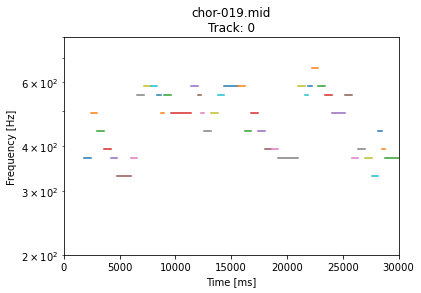

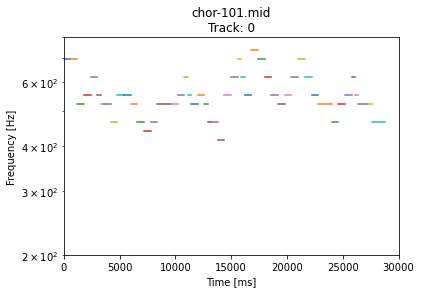

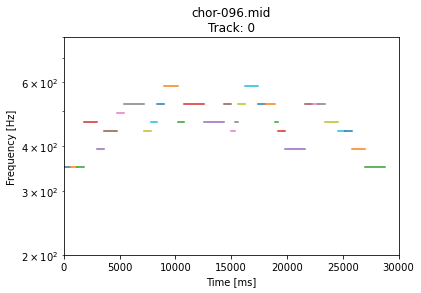

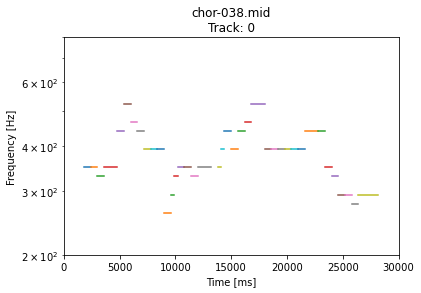

In [10]:
import librosa
import matplotlib.pyplot as plt

for song in song_book:
    tracks = song_book[song]
    
    for track in tracks:
        events = song_book[song][track]
        
        plt.figure()
        plt.title(f'{song}\nTrack: {track}')
        
        for event in events:
            # print(event)
            
            NOTE = event[0]
            START_TIME_ms = event[1]
            STOP_TIME_ms = event[2]
            
            FREQ_Hz = librosa.midi_to_hz(NOTE)
            # print(event)
            plt.plot([START_TIME_ms, STOP_TIME_ms], [FREQ_Hz, FREQ_Hz])
            
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [ms]')
        plt.xlim([0, 30000])
        plt.ylim([200, 800])
        plt.yscale('log')